In [5]:
import os
from io import BytesIO
import importlib

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import einops
import pandas as pd
# from pandas import Series

# import datasets.DeepConvLSTM.sliding_window
# importlib.reload(datasets.DeepConvLSTM.sliding_window)

from tqdm import tqdm
import scipy.signal as sg

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## HAR

In [20]:
data_path = 'Supplementary/T-WaveNet-master/data/data_har.npz'
data = np.load(data_path)

In [21]:
train_x = data['X_train']
train_x = einops.rearrange(train_x, 'b t c -> b c t')
train_y_onehot = data['Y_train']
train_y = np.argmax(train_y_onehot, axis=1)

test_x = data['X_test']
test_x = einops.rearrange(test_x, 'b t c -> b c t')
test_y_onehot = data['Y_test']
test_y = np.argmax(test_y_onehot, axis=1)
print('train_x', train_x.shape, 'train_y', train_y.shape, 'test_x', test_x.shape, 'test_y', test_y.shape)

train_x (7352, 9, 128) train_y (7352,) test_x (2947, 9, 128) test_y (2947,)


In [22]:
path_save = 'datasets/HAR/'
np.save(path_save + 'train_x.npy', train_x)
np.save(path_save + 'train_y.npy', train_y)
np.save(path_save + 'test_x.npy', test_x)
np.save(path_save + 'test_y.npy', test_y)

In [23]:
train_x.shape

(7352, 9, 128)

## OpportunityUCIDataset

In [329]:
n_samples = 46528
n_classes = 18
window_size = 48
n_channels = 77
fs = 30

In [330]:
OPPORTUNITY_DATA_FILES_TRAIN = [
    'datasets/OpportunityUCIDataset/dataset/S1-Drill.dat',
    'datasets/OpportunityUCIDataset/dataset/S1-ADL1.dat',
    'datasets/OpportunityUCIDataset/dataset/S1-ADL2.dat',
    'datasets/OpportunityUCIDataset/dataset/S1-ADL3.dat',
    'datasets/OpportunityUCIDataset/dataset/S1-ADL4.dat',
    'datasets/OpportunityUCIDataset/dataset/S1-ADL5.dat',
    'datasets/OpportunityUCIDataset/dataset/S2-Drill.dat',
    'datasets/OpportunityUCIDataset/dataset/S2-ADL1.dat',
    'datasets/OpportunityUCIDataset/dataset/S2-ADL2.dat',
    'datasets/OpportunityUCIDataset/dataset/S3-Drill.dat',
    'datasets/OpportunityUCIDataset/dataset/S3-ADL1.dat',
    'datasets/OpportunityUCIDataset/dataset/S3-ADL2.dat',
]

OPPORTUNITY_DATA_FILES_TEST = [
    'datasets/OpportunityUCIDataset/dataset/S2-ADL4.dat',
    'datasets/OpportunityUCIDataset/dataset/S2-ADL5.dat',
    'datasets/OpportunityUCIDataset/dataset/S3-ADL4.dat',
    'datasets/OpportunityUCIDataset/dataset/S3-ADL5.dat'
]

In [331]:
def feature_index():
    """Selection of the 113 columns employed in the OPPORTUNITY challenge
    :param data: numpy integer matrix
        Sensor data (all features)
    :return: numpy integer matrix
        Selection of features
    """

    #                     included-excluded
    features_delete = np.arange(0, 37)
    features_delete = np.concatenate([features_delete, np.arange(46, 50)])
    features_delete = np.concatenate([features_delete, np.arange(59, 63)])
    features_delete = np.concatenate([features_delete, np.arange(72, 76)])
    features_delete = np.concatenate([features_delete, np.arange(85, 89)])
    features_delete = np.concatenate([features_delete, np.arange(98, 102)])
    return np.delete(np.arange(134), features_delete, 0)
    # return features_delete
    
def select_columns_opp(data):
    features = feature_index()
    return data[:,features], data[:,249]

In [332]:
def feature_index_old():
    features_delete = np.arange(46, 50)
    features_delete = np.concatenate([features_delete, np.arange(59, 63)])
    features_delete = np.concatenate([features_delete, np.arange(72, 76)])
    features_delete = np.concatenate([features_delete, np.arange(85, 89)])
    features_delete = np.concatenate([features_delete, np.arange(98, 102)])
    features_delete = np.concatenate([features_delete, np.arange(134, 243)])
    features_delete = np.concatenate([features_delete, np.arange(244, 249)])
    features = np.delete(np.arange(250), features_delete)[1:-2]
    return features

In [333]:
feature_index_NORM = []
for i, f in enumerate(feature_index_old()):
    if f in feature_index():
        feature_index_NORM.append(i)
feature_index_NORM = np.asarray(feature_index_NORM)

In [334]:
feature_index_NORM

array([ 36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112])

In [335]:
NORM_MAX_THRESHOLDS = np.asarray([
    3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,
    3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,
    3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,
    3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,
    3000,   3000,   3000,   10000,  10000,  10000,  1500,   1500,   1500,
    3000,   3000,   3000,   10000,  10000,  10000,  1500,   1500,   1500,
    3000,   3000,   3000,   10000,  10000,  10000,  1500,   1500,   1500,
    3000,   3000,   3000,   10000,  10000,  10000,  1500,   1500,   1500,
    3000,   3000,   3000,   10000,  10000,  10000,  1500,   1500,   1500,
    250,    25,     200,    5000,   5000,   5000,   5000,   5000,   5000,
    10000,  10000,  10000,  10000,  10000,  10000,  250,    250,    25,
    200,    5000,   5000,   5000,   5000,   5000,   5000,   10000,  10000,
    10000,  10000,  10000,  10000,  250, 
])[feature_index_NORM]

NORM_MIN_THRESHOLDS = np.asarray([
    -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,
    -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,
    -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,
    -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,
    -3000,  -3000,  -3000,  -10000, -10000, -10000, -1000,  -1000,  -1000,
    -3000,  -3000,  -3000,  -10000, -10000, -10000, -1000,  -1000,  -1000,
    -3000,  -3000,  -3000,  -10000, -10000, -10000, -1000,  -1000,  -1000,
    -3000,  -3000,  -3000,  -10000, -10000, -10000, -1000,  -1000,  -1000,
    -3000,  -3000,  -3000,  -10000, -10000, -10000, -1000,  -1000,  -1000,
    -250,   -100,   -200,   -5000,  -5000,  -5000,  -5000,  -5000,  -5000,
    -10000, -10000, -10000, -10000, -10000, -10000, -250,   -250,   -100,
    -200,   -5000,  -5000,  -5000,  -5000,  -5000,  -5000,  -10000, -10000,
    -10000, -10000, -10000, -10000, -250, 
])[feature_index_NORM]

In [336]:
def normalize(data, max_list, min_list):
    """Normalizes all sensor channels
    :param data: numpy integer matrix
        Sensor data
    :param max_list: numpy integer array
        Array containing maximums values for every one of the 113 sensor channels
    :param min_list: numpy integer array
        Array containing minimum values for every one of the 113 sensor channels
    :return:
        Normalized sensor data
    """
    max_list, min_list = np.array(max_list), np.array(min_list)
    diffs = max_list - min_list
    for i in np.arange(data.shape[1]):
        data[:, i] = (data[:, i]-min_list[i])/diffs[i]
    #     Checking the boundaries
    data[data > 1] = 0.99
    data[data < 0] = 0.00
    return data

In [337]:
def divide_x_y(data, label):
    """Segments each sample into features and label
    :param data: numpy integer matrix
        Sensor data
    :param label: string, ['gestures' (default), 'locomotion']
        Type of activities to be recognized
    :return: numpy integer matrix, numpy integer array
        Features encapsulated into a matrix and labels as an array
    """
    data_x, data_y = data
    return data_x, data_y

In [338]:
def adjust_idx_labels(data_y, label):
    """Transforms original labels into the range [0, nb_labels-1]
    :param data_y: numpy integer array
        Sensor labels
    :param label: string, ['gestures' (default), 'locomotion']
        Type of activities to be recognized
    :return: numpy integer array
        Modified sensor labels
    """

    if label == 'locomotion':  # Labels for locomotion are adjusted
        data_y[data_y == 4] = 3
        data_y[data_y == 5] = 4
    elif label == 'gestures':  # Labels for gestures are adjusted
        data_y[data_y == 406516] = 1
        data_y[data_y == 406517] = 2
        data_y[data_y == 404516] = 3
        data_y[data_y == 404517] = 4
        data_y[data_y == 406520] = 5
        data_y[data_y == 404520] = 6
        data_y[data_y == 406505] = 7
        data_y[data_y == 404505] = 8
        data_y[data_y == 406519] = 9
        data_y[data_y == 404519] = 10
        data_y[data_y == 406511] = 11
        data_y[data_y == 404511] = 12
        data_y[data_y == 406508] = 13
        data_y[data_y == 404508] = 14
        data_y[data_y == 408512] = 15
        data_y[data_y == 407521] = 16
        data_y[data_y == 405506] = 17
    return data_y

In [339]:
def check_data(data_set):
    """Try to access to the file and checks if dataset is in the data directory
       In case the file is not found try to download it from original location
    :param data_set:
            Path with original OPPORTUNITY zip file
    :return:
    """
    print('Checking dataset {0}'.format(data_set))
    data_dir, data_file = os.path.split(data_set)
    # When a directory is not provided, check if dataset is in the data directory
    if data_dir == "" and not os.path.isfile(data_set):
        new_path = os.path.join(os.path.split(__file__)[0], "data", data_set)
        if os.path.isfile(new_path) or data_file == 'OpportunityUCIDataset.zip':
            data_set = new_path

    # When dataset not found, try to download it from UCI repository
    if (not os.path.isfile(data_set)) and data_file == 'OpportunityUCIDataset.zip':
        print('... dataset path {0} not found'.format(data_set))
        import urllib
        origin = (
            'https://archive.ics.uci.edu/ml/machine-learning-databases/00226/OpportunityUCIDataset.zip'
        )
        if not os.path.exists(data_dir):
            print('... creating directory {0}'.format(data_dir))
            os.makedirs(data_dir)
        print('... downloading data from {0}'.format(origin))
        urllib.urlretrieve(origin, data_set)

    return data_dir

In [340]:
def process_dataset_file(data, label):
    """Function defined as a pipeline to process individual OPPORTUNITY files
    :param data: numpy integer matrix
        Matrix containing data samples (rows) for every sensor channel (column)
    :param label: string, ['gestures' (default), 'locomotion']
        Type of activities to be recognized
    :return: numpy integer matrix, numy integer array
        Processed sensor data, segmented into features (x) and labels (y)
    """

    # Select correct columns
    data = select_columns_opp(data)

    # Colums are segmentd into features and labels
    data_x, data_y =  divide_x_y(data, label)
    data_y = adjust_idx_labels(data_y, label)
    data_y = data_y.astype(int)

    # Perform linear interpolation
    data_x = np.array([pd.Series(i).interpolate() for i in data_x.T]).T

    # Remaining missing data are converted to zero
    data_x[np.isnan(data_x)] = 0

    # All sensor channels are normalized
    data_x = normalize(data_x, NORM_MAX_THRESHOLDS, NORM_MIN_THRESHOLDS)

    return data_x, data_y

In [341]:
def generate_data(dataset, target_filename, label):
    """Function to read the OPPORTUNITY challenge raw data and process all sensor channels
    :param dataset: string
        Path with original OPPORTUNITY zip file
    :param target_filename: string
        Processed file
    :param label: string, ['gestures' (default), 'locomotion']
        Type of activities to be recognized. The OPPORTUNITY dataset includes several annotations to perform
        recognition modes of locomotion/postures and recognition of sporadic gestures.
    """

    data_dir = check_data(dataset)

    data_x = np.empty((0, NB_SENSOR_CHANNELS))
    data_y = np.empty((0))

    zf = zipfile.ZipFile(dataset)
    print('Processing dataset files ...')
    for filename in OPPORTUNITY_DATA_FILES:
        try:
            data = np.loadtxt(BytesIO(zf.read(filename)))
            print('... file {0}'.format(filename))
            x, y = process_dataset_file(data, label)
            data_x = np.vstack((data_x, x))
            data_y = np.concatenate([data_y, y])
        except KeyError:
            print('ERROR: Did not find {0} in zip file'.format(filename))

    # Dataset is segmented into train and test
    nb_training_samples = 557963
    # The first 18 OPPORTUNITY data files define the traning dataset, comprising 557963 samples
    X_train, y_train = data_x[:nb_training_samples,:], data_y[:nb_training_samples]
    X_test, y_test = data_x[nb_training_samples:,:], data_y[nb_training_samples:]

    print("Final datasets with size: | train {0} | test {1} | ".format(X_train.shape,X_test.shape))

    obj = [(X_train, y_train), (X_test, y_test)]
    f = file(os.path.join(data_dir, target_filename), 'wb')
    cp.dump(obj, f, protocol=cp.HIGHEST_PROTOCOL)
    f.close()

In [342]:
import datasets.DeepConvLSTM.sliding_window
importlib.reload(datasets.DeepConvLSTM.sliding_window)

def opp_sliding_window(data_x, data_y, ws, ss):
    data_x = datasets.DeepConvLSTM.sliding_window.sliding_window(data_x,(ws,data_x.shape[1]),(ss,1))
    data_y = np.asarray([[i[-1]] for i in datasets.DeepConvLSTM.sliding_window.sliding_window(data_y,ws,ss)])
    return data_x.astype(np.float32), data_y.reshape(len(data_y)).astype(np.uint8)

In [343]:
data_xs, data_ys = [], []

for data_path in tqdm(OPPORTUNITY_DATA_FILES_TRAIN):
    data =  pd.read_csv(data_path, sep=" ", header = None)
    x, y = process_dataset_file(data.values, 'gestures')
    data_x, data_y = opp_sliding_window(x, y, ws=48, ss=12)
    data_xs.append(data_x)
    data_ys.append(data_y)
    # print(data_y)

train_x = np.concatenate(data_xs, axis=0)
train_x = einops.rearrange(train_x, 'e t c -> e c t')
train_y = np.concatenate(data_ys, axis=0)
print('train_x', train_x.shape)
print('train_y', train_y.shape)

100%|██████████| 12/12 [00:08<00:00,  1.43it/s]

train_x (41375, 77, 48)
train_y (41375,)


In [346]:
np.unique(train_y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17], dtype=uint8)

In [347]:
path_save = f'datasets/OPPOR/'
np.save(path_save + 'train_x.npy', train_x)
np.save(path_save + 'train_y.npy', train_y)

In [348]:
data_xs, data_ys = [], []

for data_path in tqdm(OPPORTUNITY_DATA_FILES_TEST):
    data =  pd.read_csv(data_path, sep=" ", header = None)
    x, y = process_dataset_file(data.values, 'gestures')
    data_x, data_y = opp_sliding_window(x, y, ws=48, ss=12)
    data_xs.append(data_x)
    data_ys.append(data_y)
    # print(data_y)

test_x = np.concatenate(data_xs, axis=0)
test_x = einops.rearrange(test_x, 'e t c -> e c t')
test_y = np.concatenate(data_ys, axis=0)
print('test_x', test_x.shape)
print('test_y', test_y.shape)

100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

test_x (9882, 77, 48)
test_y (9882,)


In [349]:
path_save = f'datasets/OPPOR/'
np.save(path_save + 'test_x.npy', test_x)
np.save(path_save + 'test_y.npy', test_y)

## NinaPro

In [2]:
%%time
data_path = 'datasets/Ninapro_DB1.csv'

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [5]:
%%time
df_ninapro = pd.read_csv(data_path, sep=",")

CPU times: user 1min 6s, sys: 4.45 s, total: 1min 11s
Wall time: 2min 55s


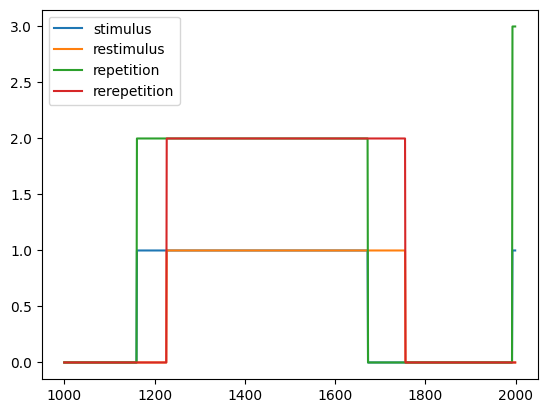

In [6]:
plt.plot(df_ninapro['stimulus'][1000:2000], label='stimulus')
plt.plot(df_ninapro['restimulus'][1000:2000], label='restimulus')
plt.plot(df_ninapro['repetition'][1000:2000], label='repetition')
plt.plot(df_ninapro['rerepetition'][1000:2000], label='rerepetition')
plt.legend()
plt.show()

In [7]:
df_ninapro_work = df_ninapro.copy()
df_ninapro_work['y'] = 0
df_ninapro_work.loc[df_ninapro_work['exercise']==1, 'y'] = df_ninapro_work[df_ninapro_work['exercise']==1]['stimulus']
df_ninapro_work.loc[df_ninapro_work['exercise']==2, 'y'] = df_ninapro_work[df_ninapro_work['exercise']==2]['stimulus'] + 12
df_ninapro_work.loc[df_ninapro_work['exercise']==3, 'y'] = df_ninapro_work[df_ninapro_work['exercise']==3]['stimulus'] + 29
df_ninapro_work = df_ninapro_work[[f'emg_{i}' for i in range(10)] + ['rerepetition', 'y']]
ninapro_x = df_ninapro_work[[f'emg_{i}' for i in range(10)]].values
ninapro_rerepetition = df_ninapro_work['rerepetition'].values
ninapro_y = df_ninapro_work['y'].values

In [8]:
rerepetition_diff = np.diff(np.concatenate([[0], ninapro_rerepetition]))
rerepetition_starts = np.where(rerepetition_diff > 0)[0]
rerepetition_stops = np.where(rerepetition_diff < 0)[0]
rerepetition_index = np.stack([rerepetition_starts, rerepetition_stops]).T

In [9]:
train_subjects = [1, 3, 4, 6, 7, 8, 9]
test_subjects = [2, 5, 10]
window = 160
step = 10

In [10]:
train_x, train_y = [], []
test_x, test_y = [], []
for i in tqdm(range(rerepetition_index.shape[0])):
    block_index_starts, block_index_stop = rerepetition_index[i,0], rerepetition_index[i,1]
    block = ninapro_x[block_index_starts:block_index_stop]
    index = ninapro_rerepetition[block_index_starts]
    y = ninapro_y[block_index_starts]
    for i in range(0, block.shape[0]-window+1, window // 2):
        x = block[i:i+window]
        if index in train_subjects:
            train_x.append(x)
            train_y.append(y)
        elif index in test_subjects:
            test_x.append(x)
            test_y.append(y)
        else:
            print(index)
train_x = np.stack(train_x)
train_x = einops.rearrange(train_x, 's t c -> s c t')
train_y = np.asarray(train_y) - 1
test_x = np.stack(test_x)
test_x = einops.rearrange(test_x, 's t c -> s c t')
test_y = np.asarray(test_y) - 1

100%|██████████| 14040/14040 [00:00<00:00, 92950.18it/s]


In [11]:
train_x.shape

(31300, 10, 160)

In [12]:
path_save = 'datasets/NinaPro/'
np.save(path_save + 'train_x.npy', train_x)
np.save(path_save + 'train_y.npy', train_y)
np.save(path_save + 'test_x.npy', test_x)
np.save(path_save + 'test_y.npy', test_y)

In [13]:
del train_x, train_y, test_x, test_y

In [14]:
# b, a = sg.butter(1, 1 / (fs_semg / 2), btype='low', output='ba')
# semgf = sg.filtfilt(b, a, semg, axis=0)

## BCICIV2a

In [6]:
class MotorImageryDataset:
    def __init__(self, dataset='A01T.npz'):
        if not dataset.endswith('.npz'):
            dataset += '.npz'

        self.data = np.load(dataset)

        self.Fs = 250  # 250Hz from original paper

        # keys of data ['s', 'etyp', 'epos', 'edur', 'artifacts']
        self.raw = self.data['s'].T
        self.events_type = self.data['etyp'].T
        self.events_position = self.data['epos'].T
        self.events_duration = self.data['edur'].T
        self.artifacts = self.data['artifacts'].T

        # Types of motor imagery
        self.mi_types = {769: 'left', 770: 'right',
                         771: 'foot', 772: 'tongue', 783: 'unknown'}

    def get_trials(self):

        # Channel default is C3
        startrial_code = 768
        
        start_trial_events = self.events_type == startrial_code
        idxs = np.where(start_trial_events[0])[0]

        trials = []
        classes = []
        class_index = {
            'left':0,
            'right':1,
            'foot':2,
            'tongue':3,
            'unknown':4
        }
        

        for index in idxs:
            try:
                type_e = self.events_type[0, index+1]
                class_e = self.mi_types[type_e]
                classes.append(class_index[class_e])

                start = self.events_position[0, index]
                stop = start + self.events_duration[0, index]
                trial = self.raw[:,start:stop]
                trials.append(trial)
            except:
                continue
                
        trials = np.stack(trials)
        classes = np.asarray(classes)
        return trials, classes

In [7]:
Xs, Ys = [], []
window = 384

for i in tqdm(range(1,10)):
    dataset_T = MotorImageryDataset(f'datasets/bcidatasetIV2a/A0{i}T.npz')
    dataset_E = MotorImageryDataset(f'datasets/bcidatasetIV2a/A0{i}E.npz')
    XT, YT = dataset_T.get_trials()
    XE, YE = dataset_T.get_trials()
    X = np.concatenate([XT, XE], axis=0)[:,:22,:]
    XX = []
    for i in range(0, 1875-window+1, 50):
        XX.append(X[:,:,i:i+window])
    XX = np.stack(XX)
    XX = einops.rearrange(XX, 's e c t -> (e s) c t')
    
    Y = np.concatenate([YT, YE], axis=0)
    YY = np.repeat(Y, 30).reshape((-1, 30)).T
    YY = einops.rearrange(YY, 's e -> (e s)')
    
    Xs.append(XX)
    Ys.append(YY)

100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


In [8]:
for i in tqdm(range(9)):
    path_save = f'datasets/BCICIV2a/subject_left_{i}/'
    os.makedirs(path_save, exist_ok=True)

    test_x, test_y = Xs[i], Ys[i]
    train_x, train_y = [], []
    for j in range(9):
        if i!=j:
            train_x.append(Xs[j])
            train_y.append(Ys[j])
    train_x = np.concatenate(train_x, axis=0)
    train_y = np.concatenate(train_y, axis=0)
    np.save(path_save + 'train_x.npy', train_x)
    np.save(path_save + 'train_y.npy', train_y)
    np.save(path_save + 'test_x.npy', test_x)
    np.save(path_save + 'test_y.npy', test_y)
    print('train_x', train_x.shape, 'train_y', train_y.shape, 'test_x', test_x.shape, 'test_y', test_y.shape)

 11%|█         | 1/9 [00:09<01:15,  9.48s/it]

train_x (123300, 22, 384) train_y (123300,) test_x (16380, 22, 384) test_y (16380,)


 22%|██▏       | 2/9 [00:31<01:57, 16.76s/it]

train_x (123480, 22, 384) train_y (123480,) test_x (16200, 22, 384) test_y (16200,)


 33%|███▎      | 3/9 [00:52<01:53, 18.88s/it]

train_x (123480, 22, 384) train_y (123480,) test_x (16200, 22, 384) test_y (16200,)


 44%|████▍     | 4/9 [01:14<01:39, 19.93s/it]

train_x (123960, 22, 384) train_y (123960,) test_x (15720, 22, 384) test_y (15720,)


 56%|█████▌    | 5/9 [01:36<01:22, 20.61s/it]

train_x (123960, 22, 384) train_y (123960,) test_x (15720, 22, 384) test_y (15720,)


 67%|██████▋   | 6/9 [01:57<01:03, 21.01s/it]

train_x (126540, 22, 384) train_y (126540,) test_x (13140, 22, 384) test_y (13140,)


 78%|███████▊  | 7/9 [02:19<00:42, 21.18s/it]

train_x (123420, 22, 384) train_y (123420,) test_x (16260, 22, 384) test_y (16260,)


 89%|████████▉ | 8/9 [02:40<00:21, 21.28s/it]

train_x (123840, 22, 384) train_y (123840,) test_x (15840, 22, 384) test_y (15840,)


100%|██████████| 9/9 [03:06<00:00, 20.76s/it]

train_x (125460, 22, 384) train_y (125460,) test_x (14220, 22, 384) test_y (14220,)


In [4]:
24 * 2 * 2 * 2 * 2

384